<a href="https://colab.research.google.com/github/BarGinger/ExplainableAIRadiology/blob/main/ex_1_final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Enable the widgets extension for JupyterLab
%pip install jupyterlab_widgets
%pip install ipywidgets
%pip install --upgrade torchsummary
%pip install torch-summary
%pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 71.9 MB/s eta 0:00:00


In [2]:
# Importing libraries
import pandas as pd
# from preprocessing_utils import  get_class_names, get_policies, get_datasets, transform_dataset
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
# from training_utils import train_model, predict_model, load_model, plot_roc_curve
from torchsummary import summary
import torchvision.models as models

### Define Global objects

In [16]:
# Global helper functions
def get_class_names():
    return [
        'Pleural Effusion'
    ]

def get_policies():
    return [
        'ones',
        'zeroes',
        'mixed'
    ]

# Global variables

# Define the class names for the medical conditions
class_names = get_class_names()

# Define the policies for dataset preparation
policies = get_policies()

# Path to the zip file
zip_path = "./chexpert.zip"

# Path to the zip file in Google Drive
zip_file_in_drive = '/content/drive/MyDrive/chexpert.zip'  # Change this to your desired location

# Path to the directory where the datasets will be extracted
data_dir = "./CheXpert-v1.0-small"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the batch size
batch_size = 16

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

In [5]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1+cu124
12.4
90300
True


# Dataset class

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os


class CheXpertDataset(Dataset):
    def __init__(self, dataframe, class_names, zip_path, transform=None):
        self.dataframe = dataframe
        self.class_names = class_names
        self.transform = transform #use this later on to resize images and pre-process if we need it

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        FOLDER = ""
        img_path = FOLDER + img_path
        image = Image.open(img_path).convert('L') # Convert to gray scalse   .convert('RGB')  #rgb format
        labels = self.dataframe.iloc[idx][self.class_names].values.astype('float32')  # astype float32 otherwise error
        labels = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels

# Models classes

## Stacked model

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.models as models

class StackedModel(nn.Module):
    def __init__(self, n_labels, freeze_layers):
        super(StackedModel, self).__init__()
        self.base_model1 = models.mobilenet_v2(pretrained=True)
        self.base_model2 = models.densenet169(pretrained=True)

        # Modify the first convolutional layer to accept 1-channel input for MobileNetV2
        self.base_model1.features[0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # Modify the first convolutional layer to accept 1-channel input for DenseNet169
        self.base_model2.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        if freeze_layers:
            for param in self.base_model1.parameters():
                param.requires_grad = False
            for param in self.base_model2.parameters():
                param.requires_grad = False


        # # Ensure the modified first layers are not frozen
        # self.base_model1.features[0][0].weight.requires_grad = True
        # self.base_model2.features.conv0.weight.requires_grad = True

        self.base_model1.classifier = nn.Identity()
        self.base_model2.classifier = nn.Identity()

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(1664 + 1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.base_model1.features(x)
        x1 = self.global_avg_pool(x1)
        x1 = torch.flatten(x1, 1)

        x2 = self.base_model2.features(x)
        x2 = self.global_avg_pool(x2)
        x2 = torch.flatten(x2, 1)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

def upload_stacked_models(n_labels=1, freeze_layers=True):
    """
    Create a stacked model using DenseNet169 and MobileNetV2 as base models.

    Parameters:
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.

    Returns:
    - The stacked model.
    """
    model = StackedModel(n_labels, freeze_layers)
    return model

# Preprocessing utils functions

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


# Global preprocessing functions

def prepare_dataset(dataframe, policy, class_names):
    """
    Prepare the dataset by filtering, shuffling, and filling missing values.

    Parameters:
    - dataframe: The input DataFrame containing the dataset.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.

    Returns:
    - x_path: Numpy array of image paths.
    - y: Numpy array of labels corresponding to the class names.
    """


    # Count the occurrences of each unique value in the "Pleural Effusion" column
    pleural_effusion_counts = dataframe['Pleural Effusion'].value_counts()

    # Print the counts for each class
    print(f"in dataframe Count for each class:\n{pleural_effusion_counts}")


    # Filter the dataset to include only frontal images
    dataset_df = dataframe[dataframe['Frontal/Lateral'] == 'Frontal']

    dataset_df = dataset_df.dropna(subset=['Pleural Effusion'])

     # Count the occurrences of each unique value in the "Pleural Effusion" column
    pleural_effusion_counts = dataset_df['Pleural Effusion'].value_counts()

    # Print the counts for each class
    print(f"in dataset_df (only Frontal) Count for each class:\n{pleural_effusion_counts}")

    # # Shuffle the dataset
    # df = dataset_df.sample(frac=1., random_state=1)

    # Fill missing values with zeros
    # df.fillna(0, inplace=True)

    # Extract image paths and labels
    x_path = dataset_df["Path"].to_numpy()
    y_df = dataset_df[class_names]

    # Count the occurrences of each unique value in the "Pleural Effusion" column
    pleural_effusion_counts = y_df.value_counts()
    print(f"in y_df Count for each class:\n{pleural_effusion_counts}")

    # Define classes to be treated as ones in the "mixed" policy
    class_ones = ['Atelectasis', 'Cardiomegaly']

    # Initialize the labels array
    y = np.empty(y_df.shape, dtype=int)

    # Define a dictionary to map policies to their corresponding actions
    policy_actions = {
        "ones": lambda cls: 1,
        "zeroes": lambda cls: 0,
        "mixed": lambda cls: 1 if cls in class_ones else 0
    }

    # Iterate over each row in the labels DataFrame
    for i, (index, row) in enumerate(y_df.iterrows()):
        labels = []
        # Iterate over each class name
        for cls in class_names:
            curr_val = row[cls]
            if curr_val:
                curr_val = float(curr_val)
                if curr_val == 1:
                    feat_val = 1
                elif curr_val == -1:
                    feat_val = policy_actions.get(policy, lambda cls: 0)(cls)
                else:
                    feat_val = 0
            else:
                feat_val = 0

            labels.append(feat_val)

        # Assign the labels to the corresponding row in the labels array
        y[i] = labels

    # Assuming y is a numpy array
    # Flatten the y array
    y_flattened = y.flatten()

    # Convert the flattened array to a pandas Series
    y_series = pd.Series(y_flattened)

    # Get the value counts of each unique value
    pleural_effusion_counts = y_series.value_counts()
    print(f"in y (labels) Count for each class:\n{pleural_effusion_counts}")

    return x_path, y

def split_train_val(train_df, policy, class_names, test_size=0.2, random_state=42):
    """
    Split the training data into training and validation sets.

    Parameters:
    - train_df: DataFrame containing the training data.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.
    - test_size: Proportion of the training data to include in the validation set.
    - random_state: Random seed for reproducibility.

    Returns:
    - train_df: DataFrame containing the training data.
    - val_df: DataFrame containing the validation data.
    """
    # Prepare the training dataset
    train_paths, train_labels = prepare_dataset(train_df, policy, class_names)

    # Split the training dataset into training and validation sets
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=test_size, random_state=random_state
    )

    # Create DataFrames for the training and validation sets
    train_df = pd.DataFrame({'path': train_paths})
    train_labels_df = pd.DataFrame(train_labels, columns=class_names)
    train_df = pd.concat([train_df, train_labels_df], axis=1)

    val_df = pd.DataFrame({'path': val_paths})
    val_labels_df = pd.DataFrame(val_labels, columns=class_names)
    val_df = pd.concat([val_df, val_labels_df], axis=1)

    return train_df, val_df

def prepare_test_dataset(valid_df, policy, class_names):
    """
    Prepare the test dataset (original validation set).

    Parameters:
    - valid_df: DataFrame containing the original validation data.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.

    Returns:
    - test_df: DataFrame containing the test data.
    """
    # Prepare the test dataset
    test_paths, test_labels = prepare_dataset(valid_df, policy, class_names)

    # Create DataFrame for the test set
    test_df = pd.DataFrame({'path': test_paths})
    test_labels_df = pd.DataFrame(test_labels, columns=class_names)
    test_df = pd.concat([test_df, test_labels_df], axis=1)

    return test_df


def get_datasets(zip_path='chexpert.zip'):
    """
    Get the training, validation, and test datasets.
    """
    # Read the training and validation data from the zip file
    original_train_df, test_df = read_zip(zip_path=zip_path)

    # Count the occurrences of each unique value in the "Pleural Effusion" column
    pleural_effusion_counts = original_train_df['Pleural Effusion'].value_counts()

    # Print the counts for each class
    print(f"in original_train_df Count for each class:\n{pleural_effusion_counts}")

    policies = get_policies()
    class_names = get_class_names()

    # Select the policy to handle uncertain labels (-1)
    # We started with mixed policy which changed -1  to 0 but got bad results so switched to ones policy
    # which changes -1 to 1
    selected_policy = policies[0]

    # Split the original training data into separate training
    # and validation sets while preserving the original
    # validation test set as the final test set.
    train_df, validation_df = split_train_val(original_train_df, selected_policy, class_names)

    # Prepare the test dataset
    test_df = prepare_test_dataset(test_df, selected_policy, class_names)

    return train_df, validation_df, test_df


def read_zip(zip_path='chexpert.zip'):
    """
    Reading training and validation data from a zip file.
    """
    original_train_df, test_df = None, None

    # Read CSV files from the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open('train.csv') as train_file:
            original_train_df = pd.read_csv(train_file)
        with zip_ref.open('valid.csv') as valid_file:
            test_df = pd.read_csv(valid_file)

    return original_train_df, test_df


def get_transform(augment=False):
    # Define the transformation pipeline for the images
    transform_list = [
        # transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
        transforms.ToTensor(),          # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
    ]

    if augment:
        # Add data augmentation transformations to help with generalization
        # RandomHorizontalFlip: Randomly flip the image horizontally
        # RandomRotation: Randomly rotate the image by up to 10 degrees
        # RandomResizedCrop: Randomly crop the image to 224x224 pixels
        # ColorJitter: Randomly change the brightness, contrast, saturation, and hue of the image
        augmentations = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate the image
            transforms.RandomPerspective(distortion_scale=0.2, p=0.5)  # Apply random perspective transformation
        ]
        transform_list = augmentations + transform_list

    transform = transforms.Compose(transform_list)
    return transform

def transform_dataset(df, zip_path='chexpert.zip', batch_size=16, shuffle=True, augment=False):
    """
    Transform the dataset into DataLoader objects for given dataframe.

    Parameters:
    - df: DataFrame containing the dataset.
    - zip_path: Path to the zip file containing the images.
    - batch_size: Number of samples in each batch.
    - shuffle: Whether to shuffle the data.
    - augment: Whether to apply data augmentation.

    Returns:
    - dataset: CheXpertDataset object containing the dataset.
    - loader: DataLoader object containing the dataset.
    - images: Batch of images from the DataLoader.
    - labels: Batch of labels from the DataLoader.
    """
    # Define the class names for the medical conditions
    class_names = get_class_names()

    transformer = get_transform(augment=augment)

    # Create the training dataset with the defined transformations
    dataset = CheXpertDataset(dataframe=df, class_names=class_names, zip_path=zip_path, transform=transformer)

    # Create DataLoader for the training dataset
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    # Verify data loading by fetching a batch of images and labels from the training DataLoader
    images, labels = next(iter(loader))

    return dataset, loader, images, labels

# Train model functions

In [23]:
import os

# Check if the folder exists
if not os.path.exists('finetuned_models'):
  # Create the folder if it doesn't exist
  os.makedirs('finetuned_models')
  print("Folder 'finetuned_models' created successfully.")
else:
  print("Folder 'finetuned_models' already exists.")


Folder 'finetuned_models' created successfully.


In [8]:
## Helper functions for training PyTorch models.

import os
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def train_model(model, train_loader: DataLoader, test_loader: DataLoader, criterion, optimizer, scheduler, num_epochs=5, model_name='model', device='cuda', patience=5):
    """
    Train a PyTorch model with the given parameters.

    Parameters:
    - model: The PyTorch model to be trained.
    - train_loader: DataLoader for the training dataset.
    - test_loader: DataLoader for the validation dataset.
    - criterion: The loss function.
    - optimizer: The optimizer.
    - scheduler: The learning rate scheduler.
    - num_epochs: Number of epochs to train the model.
    - model_name: model name to save the trained model.
    - device: Device to train the model on ('cpu' or 'cuda').
    - patience: Number of epochs to wait for improvement before stopping early.

    Returns:
    - train_losses: List of training losses for each epoch.
    - train_accuracies: List of training accuracies for each epoch.
    - test_losses: List of validation losses for each epoch.
    - test_accuracies: List of validation accuracies for each epoch.
    - test_aucs: List of validation AUCs for each epoch.
    """
    model.to(device)

    current_dir = os.getcwd()
    save_filename = f"{model_name}.pkl"
    save_path = f"finetuned_models/{save_filename}"

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    test_aucs = []

    best_loss = float('inf')
    epochs_no_improve = 0

    print(f"Training {model_name} model for {num_epochs} epochs")
    for epoch in range(num_epochs):
        model.train()
        total_train = 0
        correct_train = 0
        train_loss = 0.0

        # Add a progress bar for the training loop
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Accuracy and loss calculation
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                # Calculate accuracy per sample (averaged over labels)
                correct_train += (predicted == labels).sum().item() / labels.size(1)
                total_train += labels.size(0)
                train_loss += loss.item()

                pbar.update(1)

        # Store the average metrics for this epoch
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation phase (Test set)
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0
        all_labels = []
        all_outputs = []

        with tqdm(total=len(test_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Evaluation", unit="batch") as pbar:
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item() / labels.size(1)
                    test_loss += criterion(outputs, labels).item()

                    all_labels.append(labels.cpu().numpy())
                    all_outputs.append(outputs.cpu().numpy())

                    pbar.update(1)

        test_accuracy = correct_test / total_test
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        # Calculate AUC
        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)
        test_auc = roc_auc_score(all_labels, all_outputs)
        test_aucs.append(test_auc)

        # Print the results for this epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}, Test AUC: {test_aucs[-1]:.4f}")

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(all_labels, all_outputs)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - Epoch {epoch + 1}')
        plt.legend(loc="lower right")
        plt.show()

        # Early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model for epoch {epoch + 1} for model {model_name}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1} for model {model_name}")
                break

        # Adjust the learning rate based on the validation loss
        scheduler.step(test_loss)

    save_model(model, model_name=model_name, device=device)

    return train_losses, train_accuracies, test_losses, test_accuracies, test_aucs


def upload_pretrained_densenet169(pretrained_model, add_layers=True, n_labels=1, freeze_layers=True, unfreeze_modules=['features.denseblock4']):
    """
    Modify a pre-trained model by adding custom layers and optionally freezing the original layers.

    Parameters:
    - pretrained_model: The pre-trained model to be modified.
    - add_layers: Boolean indicating whether to add custom layers.
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.
    - unfreeze_layers: List of layer names or indices to unfreeze (e.g., 'features.denseblock4' or [6, 7] for certain blocks).

    Returns:
    - The modified model.
    """

    # Step 1: Freeze all layers
    if freeze_layers:
        for param in pretrained_model.parameters():
            param.requires_grad = False

    # Step 2: Unfreeze specific layers (if specified)
    if unfreeze_modules:
        for name, child in pretrained_model.named_modules():
            # Unfreeze layers based on the name of the block (e.g., 'features.denseblock4')
            if any(layer_name in name for layer_name in unfreeze_modules):
                # print('Works')
                for param in child.parameters():
                    param.requires_grad = True

    # Step 3: Modify the first convolutional layer to accept 1-channel input for DenseNet169
    pretrained_model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Step 4: Add custom layers if specified
    if add_layers:
        in_features = pretrained_model.classifier.in_features
        pretrained_model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_labels)
        )

    return pretrained_model


def upload_pretrained_vit(vit_model, add_layers=True, n_labels=5, freeze_layers=True):
    """
    Modify a pre-trained Vision Transformer (ViT) model by adding custom layers and optionally freezing the original layers.

    Parameters:
    - vit_model: The pre-trained ViT model to be modified.
    - add_layers: Boolean indicating whether to add custom layers.
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.

    Returns:
    - The modified ViT model.
    """
    if freeze_layers:
        for param in vit_model.parameters():
            param.requires_grad = False

    if add_layers:
        # Access the first module inside the Sequential container to get in_features
        if isinstance(vit_model.heads, nn.Sequential):
            in_features = vit_model.heads[0].in_features
        else:
            in_features = vit_model.heads.in_features

        vit_model.heads = nn.Sequential(
            nn.Linear(in_features, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, n_labels)
        )

    return vit_model

def upload_pretrained_densenet121(pretrained_model, add_layers=True, n_labels=1, freeze_layers=True):
    if freeze_layers:
        for param in pretrained_model.parameters():
            param.requires_grad = False

    if add_layers:
        in_features = pretrained_model.classifier.in_features
        pretrained_model.classifier = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, n_labels)
        )

    return pretrained_model


def upload_stacked_models(n_labels=1, freeze_layers=True):
    """
    Create a stacked model using DenseNet169 and MobileNetV2 as base models.

    Parameters:
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.

    Returns:
    - The stacked model.
    """
    class StackedModel(nn.Module):
        def __init__(self, n_labels, freeze_layers):
            super(StackedModel, self).__init__()
            self.base_model1 = models.densenet169(pretrained=True)
            self.base_model2 = models.mobilenet_v2(pretrained=True)

            if freeze_layers:
                for param in self.base_model1.parameters():
                    param.requires_grad = False
                for param in self.base_model2.parameters():
                    param.requires_grad = False

            self.base_model1.classifier = nn.Identity()
            self.base_model2.classifier = nn.Identity()

            self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Sequential(
                nn.Linear(1664 + 1280, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(128, n_labels),
                nn.Sigmoid()
            )

        def forward(self, x):
            x1 = self.base_model1.features(x)
            x1 = self.global_avg_pool(x1)
            x1 = torch.flatten(x1, 1)

            x2 = self.base_model2.features(x)
            x2 = self.global_avg_pool(x2)
            x2 = torch.flatten(x2, 1)

            x = torch.cat((x1, x2), dim=1)
            x = self.fc(x)
            return x

    model = StackedModel(n_labels, freeze_layers)
    return model

def save_model(model, model_name, device='cuda'):
    """
    Save a PyTorch model to a file using pickle and onnx.

    Parameters:
    - model: The PyTorch model to be saved.
    - model_name: The name of the model to save.
    """
    # # Save the trained model using pickle
    # with open(filename, 'wb') as f:
    #     pickle.dump(model, f)

    pickle_path = f"finetuned_models/{model_name}.pkl"
    print(f"Model pickled saved in {pickle_path}")
    # Save the model using pickle
    torch.save(model, pickle_path)

    pth_path = f"finetuned_models/{model_name}.pth"
    print(f"Model pth saved in {pth_path}")
    torch.save(model.state_dict(), pth_path)

    # Define dummy input for ONNX export (batch size 1, 3 channels, 224x224 image size)
    dummy_input = torch.randn(1, 1, 224, 224).to(device)  # Move dummy input to GPU

    # Export the model to ONNX format
    onnx_path = f"finetuned_models/{model_name}.onnx"
    torch.onnx.export(model, dummy_input, onnx_path,
                    input_names=["input"],
                    output_names=["output"],
                    opset_version=11)

    print(f"Model saved as onnx in {onnx_path}")


def load_model(filename, device='cuda'):
    """
    Load a PyTorch model from a file using the specified model class.

    Parameters:
    - model_class: The class of the model to be loaded.
    - filename: The name of the file to load the model from.
    - device: Device to load the model on ('cpu' or 'cuda').

    Returns:
    - The loaded PyTorch model.
    """
    path = f"finetuned_models/{filename}"
    loaded_model = torch.load(path, map_location=device)
    return loaded_model


def predict_model(model, loader, device='cuda'):
    """
    Predict using a trained PyTorch model.

    Parameters:
    - model: The trained PyTorch model.
    - loader: DataLoader for the dataset to predict on.
    - device: Device to run the predictions on ('cpu' or 'cuda').

    Returns:
    - predictions: Numpy array of predictions.
    - labels: Numpy array of true labels.
    """
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Function to plot ROC curve
def plot_roc_curve(labels, preds, model_name):
    """
    Plot the ROC curve for the given model.

    Parameters:
    - labels: Numpy array of true labels.
    - preds: Numpy array of predicted probabilities.
    - model_name: Name of the model.

    Returns:
    - None
    """
    class_names = get_class_names()
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for model {model_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

### Download dataset from Kaggle or Google Drive

In [17]:
  from google.colab import drive
  # Mount Google Drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import shutil
import subprocess
from google.colab import drive

# Check if Google Drive is mounted and the zip file exists
drive_mounted = os.path.exists('/content/drive')
zip_in_drive = os.path.exists(zip_file_in_drive)

# Use the zip file from Google Drive if available, otherwise download
if drive_mounted and zip_in_drive:
    print("Using dataset from Google Drive.")
    zip_path = zip_file_in_drive  # Update zip_path to use the Drive location
else:
    print("Dataset not found in Google Drive. Downloading...")
    # Check if the dataset is already downloaded locally, if not download it
    print(f"checking if dataset zip file exists at {zip_path}")
    if not os.path.exists(zip_path):
        print("Downloading the dataset...")
        # Check if kaggle is installed
        try:
            subprocess.run(["kaggle", "--version"], check=True)
            print("Kaggle is already installed.")
        except subprocess.CalledProcessError:
            print("Kaggle is not installed. Installing kaggle...")
            !pip install kaggle

        # Check if the file already exists in the destination
        kaggle_json_path = os.path.expanduser('~/.kaggle/kaggle.json')
        if not os.path.exists('kaggle.json') and not os.path.exists(kaggle_json_path):
            # Move kaggle.json to ~/.kaggle
            os.makedirs(os.path.dirname(kaggle_json_path), exist_ok=True)
            shutil.move('kaggle.json', kaggle_json_path)
            # Set permissions
            os.chmod(kaggle_json_path, 0o600)
        else:
            print("kaggle.json already exists in the destination.")

        # Download the dataset
        subprocess.run(["kaggle", "datasets", "download", "-d", "ashery/chexpert"], check=True)

        print("Dataset was downloaded from kaggle")

        if drive_mounted:
          print("Saving dataset to Google Drive for future use.")
          shutil.copy(zip_path, zip_file_in_drive)
          print(f"Dataset saved to {zip_file_in_drive}")

    else:
        print("Dataset already downloaded.")

checking if dataest zip file exists at ./chexpert.zip
Kaggle is already installed.
kaggle.json already exists in the destination.


### Extract the zip file to improve performance

In [10]:
import zipfile

# Check if the dataset is already extracted, if not extract it
if not os.path.exists(data_dir):
    print("Extracting the dataset...")
    #unzip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    #list files in the extracted dir
    os.listdir(data_dir)
else:
    print("Dataset already extracted.")

Extracting the dataset...


## Save zip to google drive if you want to save time next time running this notebook

### Load train, validtion and test datasets

In [11]:
# Load the datasets
train_df, validation_df, test_df = get_datasets(zip_path)

if train_df is None or validation_df is None or test_df is None:
    print("Error loading the datasets.")
else:
    print("Datasets loaded successfully.")

in original_train_df Count for each class:
Pleural Effusion
 1.0    86187
 0.0    35396
-1.0    11628
Name: count, dtype: int64
in dataframe Count for each class:
Pleural Effusion
 1.0    86187
 0.0    35396
-1.0    11628
Name: count, dtype: int64
in dataset_df (only Frontal) Count for each class:
Pleural Effusion
 1.0    76899
 0.0    25299
-1.0     9578
Name: count, dtype: int64
in y_df Count for each class:
Pleural Effusion
 1.0                76899
 0.0                25299
-1.0                 9578
Name: count, dtype: int64
in y (labels) Count for each class:
1    86477
0    25299
Name: count, dtype: int64
in dataframe Count for each class:
Pleural Effusion
0.0    167
1.0     67
Name: count, dtype: int64
in dataset_df (only Frontal) Count for each class:
Pleural Effusion
0.0    138
1.0     64
Name: count, dtype: int64
in y_df Count for each class:
Pleural Effusion
0.0                 138
1.0                  64
Name: count, dtype: int64
in y (labels) Count for each class:
0    138

#### Peak into training dataset

In [12]:
# Print some information about the train DataFrame
display(train_df.head())
print("Number of rows and columns in the train DataFrame:", train_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(train_df.dtypes)

# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = train_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

,path,Pleural Effusion
0,CheXpert-v1.0-small/train/patient16646/study1/...,1
1,CheXpert-v1.0-small/train/patient10056/study9/...,1
2,CheXpert-v1.0-small/train/patient42372/study4/...,1
3,CheXpert-v1.0-small/train/patient45046/study5/...,1
4,CheXpert-v1.0-small/train/patient05198/study2/...,0


Number of rows and columns in the train DataFrame: (89420, 2)
Column names and data types:
path                object
Pleural Effusion     int64
dtype: object
Count for each class:
Pleural Effusion
1    69302
0    20118
Name: count, dtype: int64


### Peak into the validation dataset

In [13]:
# Print some information about the validtion DataFrame
# Set pandas display options to show all columns
display(validation_df.head())
print("Number of rows and columns in the validation DataFrame:", validation_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(validation_df.dtypes)

# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = validation_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

,path,Pleural Effusion
0,CheXpert-v1.0-small/train/patient48924/study2/...,1
1,CheXpert-v1.0-small/train/patient38687/study1/...,1
2,CheXpert-v1.0-small/train/patient03187/study2/...,1
3,CheXpert-v1.0-small/train/patient37033/study15...,1
4,CheXpert-v1.0-small/train/patient25492/study1/...,0


Number of rows and columns in the validation DataFrame: (22356, 2)
Column names and data types:
path                object
Pleural Effusion     int64
dtype: object
Count for each class:
Pleural Effusion
1    17175
0     5181
Name: count, dtype: int64


#### Peak into the test dataset

In [14]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
display(test_df.head())
print("Number of rows and columns in the test DataFrame:", test_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(test_df.dtypes)


# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = test_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

,path,Pleural Effusion
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0
2,CheXpert-v1.0-small/valid/patient64543/study1/...,0
3,CheXpert-v1.0-small/valid/patient64544/study1/...,0
4,CheXpert-v1.0-small/valid/patient64545/study1/...,1


Number of rows and columns in the test DataFrame: (202, 2)
Column names and data types:
path                object
Pleural Effusion     int64
dtype: object
Count for each class:
Pleural Effusion
0    138
1     64
Name: count, dtype: int64


#### Dataset formation according to torch (using dataloaders)

In [18]:
# Transform the training dataset
train_dataset, train_loader, train_images, train_labels = transform_dataset(train_df, zip_path, batch_size=batch_size, shuffle=True, augment=True)

# Transform the validation dataset
validtion_dataset, validtion_loader, validtion_images, validtion_labels = transform_dataset(validation_df, zip_path, batch_size=batch_size, shuffle=False, augment=False)

# Transform the test dataset
test_dataset, test_loader, test_images, test_labels = transform_dataset(test_df, zip_path, batch_size=batch_size, shuffle=False, augment=False)

#### Visualising example

Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


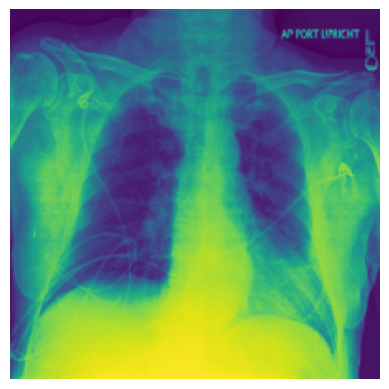

In [19]:
# Select the first image in the batch
image = test_images[0]
original_shape = image.shape
image = image.permute(1, 2, 0).numpy()  # Change shape to (224, 224)
new_shape = image.shape
print(f"Original shape: {original_shape}, New shape: {new_shape}")
# Check the shape of the image to ensure it is (224, 224, 3)
assert new_shape == (224, 224, 1), f"Expected shape (224, 224), but got {image.shape}"

# Denormalize the image for visualization
image = (image * 0.5) + 0.5

# Plot the image
print("Example image:")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

#### Here we can extract different pre-trained models

# Choose model to train, execute only the one you wish to train

### Train Stacked Models

In [ ]:
from StackedModel import upload_stacked_models

model = upload_stacked_models(n_labels=len(class_names), freeze_layers=True)

# Move the model to the appropriate device
model.to(device)

model_name = "stacked_model"

### Train Densenet169

In [20]:
# Load a pre-trained DenseNet169 model, add custom layers, and freeze certain layers
#
# Parameters:
# - pretrained: Use a pre-trained version of DenseNet169
# - add_layers: Add custom layers to the model
# - n_labels: Number of output labels (classes)
# - freeze_layers: Freeze the layers of the pre-trained model to prevent them from being updated during training
denseNet169 = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1)
model = upload_pretrained_densenet169(denseNet169, add_layers=True, n_labels=len(class_names), freeze_layers=True)

# Move the model to the appropriate device
model.to(device)

model_name = "densenet169"

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 127MB/s]


#### Summary of Model

In [21]:
summary(model, input_size=(1, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,136
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             (45,440)
|    |    └─_DenseLayer: 3-2             (49,600)
|    |    └─_DenseLayer: 3-3             (53,760)
|    |    └─_DenseLayer: 3-4             (57,920)
|    |    └─_DenseLayer: 3-5             (62,080)
|    |    └─_DenseLayer: 3-6             (66,240)
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             (512)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (32,768)
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            (53,760)
|    |    └─_DenseLayer: 3-12            (57,920)
|    |  

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,136
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             (45,440)
|    |    └─_DenseLayer: 3-2             (49,600)
|    |    └─_DenseLayer: 3-3             (53,760)
|    |    └─_DenseLayer: 3-4             (57,920)
|    |    └─_DenseLayer: 3-5             (62,080)
|    |    └─_DenseLayer: 3-6             (66,240)
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             (512)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (32,768)
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            (53,760)
|    |    └─_DenseLayer: 3-12            (57,920)
|    |  

#### Here is how we train the model

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Calculate class weights to handle class imbalance
# The weight for the positive class (Pleural Effusion = 1) is calculated as:
# total number of samples / (2 * number of positive samples)
# This ensures that the positive class is given more importance during training.
class_weights = torch.tensor([1.0, len(train_df['Pleural Effusion']) / (2 * sum(train_df['Pleural Effusion']))], dtype=torch.float32)

# Define the loss function with class weights
# criterion = nn.BCELoss(weight=class_weights[1])
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])


# Define the loss function
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class
# criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with weight decay
# Adam optimizer with learning rate of 0.0001 and weight decay
optimizer_densenet = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer_densenet, mode='min', factor=0.1, patience=5, verbose=True)

# Define the number of epochs
num_epochs = 1

# Train the model
# Parameters:
# - model: The model to be trained (DenseNet169 in this case)
# - train_loader: DataLoader for the training dataset
# - test_loader: DataLoader for the validation dataset
# - criterion: The loss function
# - optimizer: The optimizer
# - num_epochs: Number of epochs to train the model
# - device: Device to train the model on ('cpu' or 'cuda')
# - save_filename: Filename to save the trained model
train_losses, train_accuracies, test_losses, test_accuracies, test_aucs = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=validtion_loader,
    criterion=criterion,
    optimizer=optimizer_densenet,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    model_name=model_name
)

# Adjust the learning rate based on the validation loss
for epoch in range(num_epochs):
    # Training and evaluation code here...
    scheduler.step(test_losses[-1])  # Adjust the learning rate based on the latest validation loss

Training densenet169 model for 1 epochs


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

In [26]:
pickle_path = f"finetuned_models/{model_name}.pkl"
print(f"Model pickled saved in {pickle_path}")
# Save the model using pickle
torch.save(model, pickle_path)

pth_path = f"finetuned_models/{model_name}.pth"
print(f"Model pth saved in {pth_path}")
torch.save(model.state_dict(), pth_path)

# Define dummy input for ONNX export (batch size 1, 3 channels, 224x224 image size)
dummy_input = torch.randn(1, 1, 224, 224).to(device)  # Move dummy input to GPU

# Export the model to ONNX format
onnx_path = f"finetuned_models/{model_name}.onnx"
torch.onnx.export(model, dummy_input, onnx_path,
                input_names=["input"],
                output_names=["output"],
                opset_version=11)

print(f"Model saved as onnx in {onnx_path}")

Model pickled saved in finetuned_models/densenet169.pkl
Model pth saved in finetuned_models/densenet169.pth
Model saved as onnx in finetuned_models/densenet169.onnx


### Evaluate the trained model

<ipython-input-8-ee60f31cfcd9>:367: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(path, map_location=device)


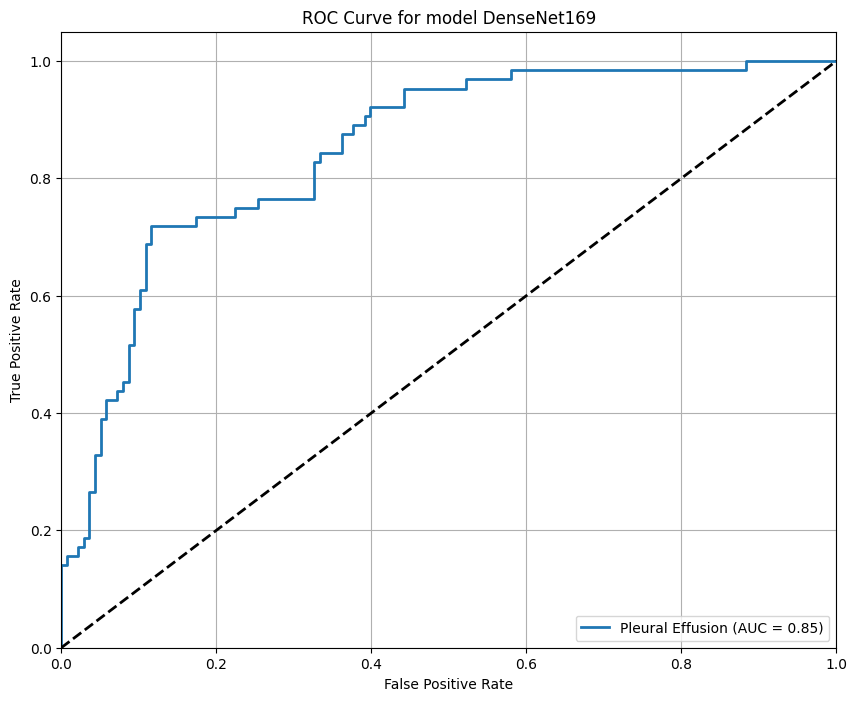

In [27]:
model = load_model(filename="densenet169.pkl", device=device)
test_preds, test_labels = predict_model(model, test_loader, device)
# Plot ROC curve for the test dataset
plot_roc_curve(test_labels, test_preds, model_name='DenseNet169')

In [ ]:
from training_utils import load_model

model = load_model(filename="stacked_model.pkl", device=device)
test_preds, test_labels = predict_model(model, test_loader, device)
# Plot ROC curve for the test dataset
plot_roc_curve(test_labels, test_preds, model_name='Stacked Model')